## MSDS: 7337 - Natural Language Processing
**Author: Trace Smith**
**Homework Assignment: 8**
________

**Assignment Questions**

- Load one of the sentiment vocabularies referenced in the textbook, and run the sentiment analyzer as explained in the corresponding reference. Add words to the sentiment vocabulary, if you think you need to, to better fit your particular text collection.


- For each of the clusters you created in homework 7, compute the average, median, high, and low sentiment scores for each cluster. Explain whether you think this reveals anything interesting about the clusters

In [1]:
# Python Libraries
import re
import nltk
import numpy as np;print("Numpy",np.__version__)
from textblob import TextBlob
import textblob
import nltk as pd;print("TextBlob",textblob.__version__)
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk as pd;print("NLTK",nltk.__version__)
import pandas as pd;print("Pandas",pd.__version__)
import matplotlib; print("Matplitlib",matplotlib.__version__)
import matplotlib.pyplot as plt
import sklearn;print('Sklearn',sklearn.__version__)
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer,CountVectorizer
import pattern
from pattern.en import sentiment;print('Pattern',pattern.__version__)
%matplotlib inline

Numpy 1.16.1
TextBlob 0.15.3
NLTK 3.3
Pandas 0.24.1
Matplitlib 1.5.3
Sklearn 0.20.3
Pattern 3.6


### Continue from Homework #7 - Load Data And Cluster Reviews

In [2]:
def load_data(file_name):
    """ 
    Load Movie Reviews
    """
    try:
        df = pd.read_csv('data/{}.csv'.format(file_name))
        print('Raw DataFrame Shape: ',df.shape)
        return df
    except KeyboardInterrupt:
        print('Error Loading Data!')
    
if __name__ == '__main__':
    
    # Load Reviews
    df = load_data('reviews')

Raw DataFrame Shape:  (800, 10)


### Convert Reviews to TF-IDF Matrix

In [4]:
def get_tokenizer(text):
    
    """ Tokenize Input Text """
    text = ''.join([str(word).lower() for word in text if word not in punctuation])
    tokens = nltk.word_tokenize(str(text))

    results = []
    for token in tokens:
        if re.search('[a-zA-Z]', token): 
            results.append(nltk.stem.WordNetLemmatizer().lemmatize(token))
    return results
def text_to_features(input):
    
    """
    Convert Reviews to a matrix of TF-IDF Features
    """
    
    vectorizer = TfidfVectorizer(stop_words='english',
                                tokenizer = get_tokenizer,
                                max_features=200000,
                                use_idf=True,
                                min_df=0.01, max_df=0.99,
                                ngram_range=(1, 3))
    
    x = vectorizer.fit_transform(input)
    terms = vectorizer.get_feature_names()
    print('Total Features:',len(terms))
    return x

if __name__ == '__main__':
    
    reviews = df['review_text'].tolist()
    tfidf = text_to_features(reviews)

/Users/tracesmith/anaconda/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Total Features: 975


### Clustering with K-Means; Determine Optimal Number of Clusters

100%|██████████| 20/20 [01:08<00:00,  3.73s/it]


19
CPU times: user 2min 30s, sys: 23.8 s, total: 2min 54s
Wall time: 1min 8s


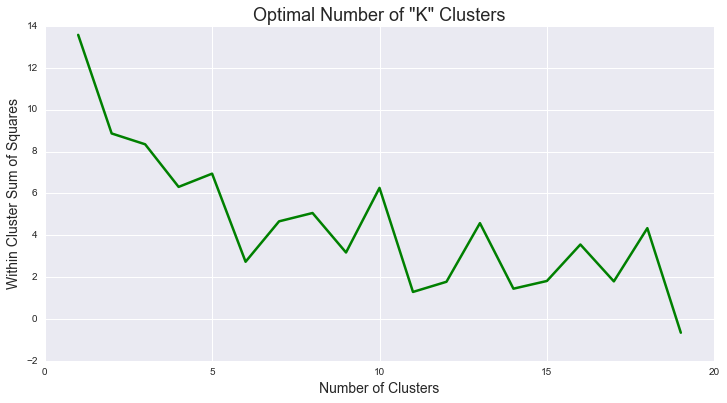

In [259]:
import tqdm
def get_optimal_number_clusters(input,clusters=20):
    """ 
    Determine the Optimal Numbers of Clusters
    """
    inertia = []
    change_inertia = []
    for i in tqdm.tqdm(range(1,clusters+1)):
        clustering = KMeans(n_clusters = i, n_init=10,max_iter=300,random_state=1,init='k-means++')
        clustering.fit(input)
        if inertia: 
            change_inertia.append(inertia[-1] - clustering.inertia_)
        inertia.append(clustering.inertia_)
    print(len(change_inertia))
    plt.figure(figsize=(12,6))
    plt.plot([i for i in range(1,clusters)], change_inertia, color='g',linewidth=2.5)
    plt.title('Optimal Number of "K" Clusters', fontsize=18)
    plt.xlabel('Number of Clusters', fontsize=14)
    plt.ylabel('Within Cluster Sum of Squares', fontsize=14)
    plt.show
    
if __name__ == '__main__':
    
    %time get_optimal_number_clusters(tfidf)

### Perform K-Means Clustering w/ Optimial Number of Clusters

In [5]:
def do_clustering(data,n_clusters):
    """ 
    Perform K-Means Clustering
    """
    km = KMeans(n_clusters = n_clusters, n_init=10,max_iter=1004,random_state=1,init='k-means++')
    km.fit(data)
    return km.labels_.tolist()
    
if __name__ == '__main__':
    
    # KMeans
    labels = do_clustering(tfidf,5)
    df['labels'] = labels

### Cluster Breakdown - Clusters = 5

In [277]:
#Cluster Breakdown by Year
df.groupby(['labels','year'])['year'].count()

labels  year
0       2019     64
1       2018     34
        2019    206
2       2018      1
        2019     48
3       2018     37
        2019     36
4       2018     28
        2019    346
Name: year, dtype: int64

In [280]:
#Cluster Breakdown by Rating
df.groupby(['labels','users_rating'])['users_rating'].count()

labels  users_rating
0       9.6             64
1       5.3             43
        6.3             41
        7.0             29
        8.0             24
        8.3             16
        8.5             34
        8.7             37
        9.6             16
2       8.3             48
        8.5              1
3       6.3              1
        8.0             34
        8.5             37
        9.6              1
4       5.3             57
        6.3             58
        7.0             71
        8.0             42
        8.3             36
        8.5             28
        8.7             63
        9.6             19
Name: users_rating, dtype: int64

In [281]:
#Cluster Breakdown by Title
df.groupby(['labels','title'])['title'].count()

labels  title                            
0       Once Upon a Time ... in Hollywood    64
1       Annabelle Comes Home                 41
        Avengers: Endgame                    37
        Once Upon a Time ... in Hollywood    16
        Spider-Man: Far from Home            24
        Spider-Man: Into the Spider-Verse    34
        The Lion King                        43
        Toy Story 4                          16
        Yesterday                            29
2       Spider-Man: Into the Spider-Verse     1
        Toy Story 4                          48
3       Annabelle Comes Home                  1
        Once Upon a Time ... in Hollywood     1
        Spider-Man: Far from Home            34
        Spider-Man: Into the Spider-Verse    37
4       Annabelle Comes Home                 58
        Avengers: Endgame                    63
        Once Upon a Time ... in Hollywood    19
        Spider-Man: Far from Home            42
        Spider-Man: Into the Spider-Verse    2

### Cluster Breakdown - Clusters = 5

In [158]:
if __name__ == '__main__':
    
    # KMeans
    labels = do_clustering(tfidf,5)
    
    # Add Labels
    df2 = df.copy()
    df2['labels'] = labels

In [159]:
#Cluster Breakdown by Year
df2.groupby(['labels','year'])['year'].count()

labels  year
0       2019     64
1       2018     34
        2019    206
2       2018      1
        2019     48
3       2018     37
        2019     36
4       2018     28
        2019    346
Name: year, dtype: int64

In [160]:
#Cluster Breakdown by Rating
df2.groupby(['labels','users_rating'])['users_rating'].count()

labels  users_rating
0       9.6             64
1       5.3             43
        6.3             41
        7.0             29
        8.0             24
        8.3             16
        8.5             34
        8.7             37
        9.6             16
2       8.3             48
        8.5              1
3       6.3              1
        8.0             34
        8.5             37
        9.6              1
4       5.3             57
        6.3             58
        7.0             71
        8.0             42
        8.3             36
        8.5             28
        8.7             63
        9.6             19
Name: users_rating, dtype: int64

In [161]:
#Cluster Breakdown by Title
df2.groupby(['labels','title'])['title'].count()

labels  title                            
0       Once Upon a Time ... in Hollywood    64
1       Annabelle Comes Home                 41
        Avengers: Endgame                    37
        Once Upon a Time ... in Hollywood    16
        Spider-Man: Far from Home            24
        Spider-Man: Into the Spider-Verse    34
        The Lion King                        43
        Toy Story 4                          16
        Yesterday                            29
2       Spider-Man: Into the Spider-Verse     1
        Toy Story 4                          48
3       Annabelle Comes Home                  1
        Once Upon a Time ... in Hollywood     1
        Spider-Man: Far from Home            34
        Spider-Man: Into the Spider-Verse    37
4       Annabelle Comes Home                 58
        Avengers: Endgame                    63
        Once Upon a Time ... in Hollywood    19
        Spider-Man: Far from Home            42
        Spider-Man: Into the Spider-Verse    2

### Sentiment Analysis Reviews

 - In this section, we will use sentiment analysis method in the pattern library to rate the review as being positive or negative. Once we have the sentiment for each review, we will run it through K-Means clustering to determine if we can segment reviews based on the overall sentiment for the IMDB movies. For each cluster, we will compute the average, median, high, and low sentiment scores for each cluster.

In [7]:
def clean_text_sentiment(x):
    """ Clean Text"""
    x = ''.join([i for i in x if not i.isdigit()])
    return x

def do_sentiment(x):
    """ Perform Sentiment Analysis"""
    blob = TextBlob(x)
    p = []
    for sentence in blob.sentences:
        p.append(sentence.sentiment.polarity)
    #Return Average Polarity of Review
    return np.max(p)

def check_results(df,review_num):
    """ Check Movie Review + Sentiment"""
    print('Review: {} - Sentiment Score: {}'.format(df['clean_text_sentiment'].tolist()[review_num],df['sentiment'].tolist()[review_num]))

if __name__ == '__main__':
    
    df['clean_text_sentiment'] = df['review_text'].apply(lambda x: clean_text_sentiment(x))
    df['sentiment'] = df['clean_text_sentiment'].apply(lambda x: do_sentiment(x))

### Cluster and Sentiment Analysis Breakdown

In [8]:
# Let's ignore sentiment scores = 0
df_s = df[df['sentiment'] != 0]

In [9]:
print('Cluster + Sentiment Mean Scores')
df_s.groupby(['labels'])['sentiment'].mean()

Cluster + Sentiment Mean Scores


labels
0    0.676765
1    0.500677
2    0.512368
3    0.698850
4    0.407487
Name: sentiment, dtype: float64

In [10]:
df_s.groupby(['labels'])['sentiment'].median()

labels
0    0.700000
1    0.500000
2    0.566667
3    0.700000
4    0.470000
Name: sentiment, dtype: float64

In [11]:
print('Cluster + Sentiment Max Scores')
df_s.groupby(['labels'])['sentiment'].max()

Cluster + Sentiment Max Scores


labels
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: sentiment, dtype: float64

In [12]:
print('Cluster + Sentiment Min Scores')
df_s.groupby(['labels'])['sentiment'].min()

Cluster + Sentiment Min Scores


labels
0    0.100000
1   -1.000000
2   -0.400000
3   -0.266667
4   -1.000000
Name: sentiment, dtype: float64

### Check Sentiment Scores with Sampled Movie Reviews

In [13]:
check_results(df_s,5)

Review: Depressing vibes from the beginning... - Sentiment Score: -0.6


In [14]:
check_results(df_s,33)

Review: Well, its toy story. They basically did the exact same plot as last one. Get stuck in an old toy shop have to find a way to escape. Key and Peele are also in it way too often. Just a huge disappointment. The spork was funny at first but too much. Just not as good. Huge let down. Would not really spend $ to see it if I knew of this. - Sentiment Score: 0.7


### Discussion

After performing sentiment analysis with TextBlob, the clusters generated using K-Means on the preprocessed movie reviews do not really provide any insightful information at this moment. Clearly, the sentiment scores are not always reflective of the true sentiment of the review as seen above in the sampled review polarity scores. Therefore, if we had a pre-trained model on the IMDB movie reviews to classify overall sentiment, as positive or negative, we could possible extract more information from these movies. Ideally, it would be great if the sentiment scores indicated the overall feeling of movie reviews, positive or negative. 

Looking deeper in the sentiment analysis, as opposed to training our own model, I looked into using MonkeyLearn's API for classifying reviews as positive or negative with a pre-trained model (Great [docs](https://monkeylearn.com/sentiment-analysis/)!). Most open-source frameworks don't have pre-trained models and you will need to train one from scratch. This sentiment analysis model was trained with data from different movie review sites to segment between good and bad reviews. Since we are limited by the number of API request, I didn't get the finish exploring this, but something to look further into and see if we can use the pre-trained model better cluster the reviews. There is an enterprise license for this tool, but using the free version we are somewhat restricted. Anyways, always nice to learn other tools out there :)

In [224]:
from monkeylearn import MonkeyLearn
def use_ml(x):
    default_api_key = '48b21a962c5e86bf8224f6c520ef28c2fb68d3b9'
    ml = MonkeyLearn(default_api_key)
    model_id = 'cl_MX2qQKNi' # Name of pre-trained movies model
    result = ml.classifiers.classify(model_id, x)
    return result.body[0]['classifications'][0]['tag_name']

In [ ]:
# Since it takes a while to run -> Limited on the number of API Request; 
df_subset = df.loc[:10]
%time df_subset['sentiment_label'] = df_subset['clean_text_sentiment'].apply(lambda x: use_ml(x))